<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Sentiment analysis con Embeddings + LSTM

### Objetivo
El objetivo es utilizar las críticas de compradores de ropa para que el sistema determine la evaluación del comprador y su crítica (cuantas estrellas le asigna al producto).

In [95]:
!pip install --upgrade --no-cache-dir gdown --quiet

In [96]:
import numpy as np
import random
import io
import pickle
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import keras
from tensorflow.keras import layers

from keras.utils.np_utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

### Datos
Utilizaremos como dataset críticas de compradores de ropa (eCommerce) los cuales puntuaron a cada prenda con un puntaje de 1 a 5 estrellas.\
Referencia del dataset: [LINK](https://www.kaggle.com/nicapotato/womens-ecommerce-clothing-reviews/version/1)

In [97]:
# Descargar la carpeta de dataset
import os
import gdown
if os.access('clothing_ecommerce_reviews.csv', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1k2Dz4oY5uxI3JEaT6m-L2T2HvLkECYIP'
    output = 'clothing_ecommerce_reviews.csv'
    gdown.download(url, output, quiet=False)
else:
    print("El dataset ya se encuentra descargado")

El dataset ya se encuentra descargado


In [98]:
# Armar el dataset
df = pd.read_csv('clothing_ecommerce_reviews.csv')
df.drop(columns = ['Unnamed: 0'], inplace = True)
df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


### 1 - Limpieza de datos
Alumno:
- Del dataset unicamente utilizar las columnas "Review Text" y "Rating.
- Tranformar el rating 1-5 a una escala numérica de 0 a 4.



In [99]:
df_reviews = df.loc[:, ['Review Text', 'Rating']].dropna()
df_reviews['Rating'] = df_reviews['Rating'] - 1
df_reviews.head()

,Review Text,Rating
0,Absolutely wonderful - silky and sexy and comf...,3
1,Love this dress! it's sooo pretty. i happene...,4
2,I had such high hopes for this dress and reall...,2
3,"I love, love, love this jumpsuit. it's fun, fl...",4
4,This shirt is very flattering to all due to th...,4


In [100]:
# Alumno: Observar como está distribuido el dataset respecto a la columna Rating
# es decir, observar que tan balanceado se encuentra respecot a cada clase
df_reviews['Rating'].value_counts()

4    12540
3     4908
2     2823
1     1549
0      821
Name: Rating, dtype: int64

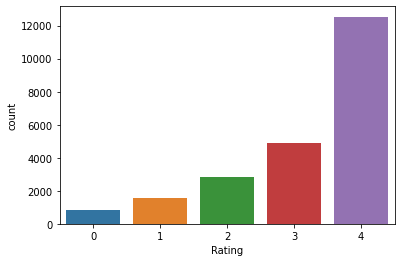

In [101]:
# Observar como está distribuido el dataset
sns.countplot(x='Rating', data=df_reviews)
plt.show()

In [102]:
# Alumno: tomar la columna de las review y almacenarlo todo en un vector numpy de reviews
text_sequences = df_reviews['Review Text'].values
text_sequences.shape

(22641,)

In [103]:
# Alumno: Cuantas reviews (rows) hay para evaluar?
len(text_sequences)

22641

In [104]:
# Alumno: Concatenar todas las reviews para armar el corpus
corpus = ' '.join(text_sequences)

In [105]:
# Alumno: ¿Cuál es la longitud de ese corpus?
len(corpus)

7011643

In [106]:
# Alumno: Utilizar "text_to_word_sequence" para separar las palabras en tokens
# recordar que text_to_word_sequence automaticamente quita los signos de puntuacion y pasa el texto a lowercase
from keras.preprocessing.text import text_to_word_sequence
tokens = text_to_word_sequence(corpus)

In [107]:
# Alumno: Dar un vistazo a los primeros 20 tokens/palabras
tokens[:20]

['absolutely',
 'wonderful',
 'silky',
 'and',
 'sexy',
 'and',
 'comfortable',
 'love',
 'this',
 'dress',
 "it's",
 'sooo',
 'pretty',
 'i',
 'happened',
 'to',
 'find',
 'it',
 'in',
 'a']

In [108]:
# Alumno: ¿Cuántos tokens/palabras hay?
len(tokens)

1372203

In [109]:
# Alumno: Tokenizar las palabras con el Tokenizer de Keras
# Definir una máxima cantidad de palabras a utilizar:
# num_words --> the maximum number of words to keep, based on word frequency.
# Only the most common num_words-1 words will be kept.
from keras.preprocessing.text import Tokenizer
num_words = 2000
vocab_size = num_words
tok = Tokenizer(num_words=2000) 
tok.fit_on_texts(tokens)

In [110]:
# Alumno: Obtener el diccionario de palabra (word) a índice
# y observar la cantidad total del vocabulario
word_index = tok.word_index
len(word_index)

14847

In [111]:
# Alumno: Convertir las palabras/tokens a números
sequences = tok.texts_to_sequences(text_sequences)

In [112]:
sequences[0][:10]

[253, 532, 917, 3, 662, 3, 68]

In [113]:
# Alumno: Determinar cual es la oración más larga
max(len(s) for s in sequences)

115

In [114]:
# Alumno: Realizar padding de las sentencias al mismo tamaño
# tomando de referencia la máxima sentencia
from keras.preprocessing.sequence import pad_sequences
maxlen = 115

# Al realizar padding obtener la variable "X" (input)
X = pad_sequences(sequences, padding='pre', maxlen=maxlen)

In [115]:
# Alumno: Observar las dimensiones de la variable input
X.shape

(22641, 115)

In [116]:
# Alumno: tomar la columna rating y alcemacenarla en una variable "y" transformada a oneHotEncoding
# Su shape debe ser equivalente la cantidad de rows del corpus y a la cantidad
# de clases que se deseen predecir (en este ejemplo son 5)
y = df_reviews['Rating'].values
y = to_categorical(y) #One hot encoder de Keras
print(y.shape)

(22641, 5)


In [117]:
# Alumno: Dividir los datos en train y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

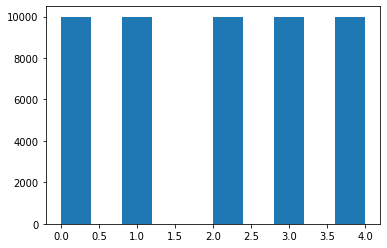

In [118]:
# Debido al desbalance en las clases de la variable de salida, utilizo un modelo de resampleo
from imblearn.over_sampling import SMOTE
# transform the dataset
oversample = SMOTE()
X_train_os, y_train_os = oversample.fit_resample(X_train, y_train)
#y_os = to_categorical(y_os) #One hot encoder de Keras

# plot the distribution
plt.hist(np.argmax(y_train_os, axis=1))
plt.show()

In [119]:
# Alumno: determinar la dimensiones de entrada y salida
in_shape = X_train_os.shape[1] # max input sentence len
out_shape = 5 # Multi-class classification
print("in_shape", in_shape, ", out_shape", out_shape)

in_shape 115 , out_shape 5


### 2 - Entrenar el modelo con Embeddings + LSTM

In [120]:
# Alumno: Entrene su modelo con LSTM entrenando sus propios embeddings
# o utilizando embeddings pre-entrenados.
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout

model = Sequential()
# input_dim = vocab_size (max n_words)
# input_length = setencias con padding a 115
# output_dim = 100 --> crear embeddings de tamaño 100
model.add(Embedding(input_dim=vocab_size+1, output_dim=100, input_length=in_shape))
model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=64)) # La última capa LSTM no lleva return_sequences

model.add(Dense(units=128, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(units=out_shape, activation='sigmoid'))

model.compile(optimizer="adam",
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 115, 100)          200100    
                                                                 
 lstm_4 (LSTM)               (None, 115, 64)           42240     
                                                                 
 dropout_4 (Dropout)         (None, 115, 64)           0         
                                                                 
 lstm_5 (LSTM)               (None, 64)                33024     
                                                                 
 dense_4 (Dense)             (None, 128)               8320      
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 5)                

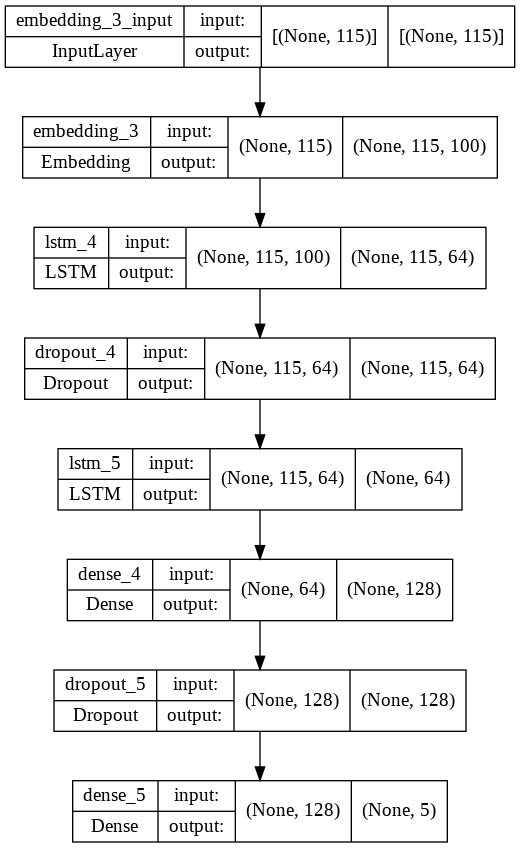

In [121]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [122]:
hist = model.fit(X_train_os, y_train_os, epochs=50, validation_split=0.2)

Epoch 1/50
1250/1250 [==============================] - 24s 15ms/step - loss: 1.1599 - accuracy: 0.4586 - val_loss: 4.4812 - val_accuracy: 0.0042
Epoch 2/50
1250/1250 [==============================] - 18s 15ms/step - loss: 0.9983 - accuracy: 0.5150 - val_loss: 4.2462 - val_accuracy: 0.0054
Epoch 3/50
1250/1250 [==============================] - 19s 15ms/step - loss: 0.9589 - accuracy: 0.5305 - val_loss: 4.9869 - val_accuracy: 0.0023
Epoch 4/50
1250/1250 [==============================] - 18s 14ms/step - loss: 0.9300 - accuracy: 0.5405 - val_loss: 5.2019 - val_accuracy: 0.0030
Epoch 5/50
1250/1250 [==============================] - 19s 15ms/step - loss: 0.9069 - accuracy: 0.5545 - val_loss: 5.3298 - val_accuracy: 0.0032
Epoch 6/50
1250/1250 [==============================] - 18s 14ms/step - loss: 0.8813 - accuracy: 0.5737 - val_loss: 5.1689 - val_accuracy: 0.0031
Epoch 7/50
1250/1250 [==============================] - 18s 14ms/step - loss: 0.8579 - accuracy: 0.5863 - val_loss: 5.8230 -

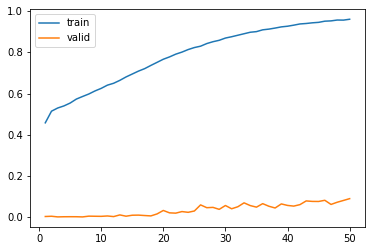

In [123]:
import matplotlib.pyplot as plt
import seaborn as sns
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

In [124]:
model.evaluate(X_test, y_test)

142/142 [==============================] - 2s 8ms/step - loss: 3.6505 - accuracy: 0.5902


[3.650472640991211, 0.5901964902877808]

In [125]:
# Metricas multiclase
def metricas_multiclase(model, X_test, y_test):
  Pred = model.predict(X_test, batch_size=32)
  Pred_Label = np.argmax(Pred, axis=1)
  y2_test = np.argmax(y_test, axis=1) #Transformo y_test nuevamente en vector
  test_acc = accuracy_score(y2_test, Pred_Label)
  ConfusionM = confusion_matrix(list(y2_test), Pred_Label, labels=[0, 1, 2, 3, 4])
  class_report = classification_report(list(y2_test), Pred_Label, labels=[0, 1, 2, 3, 4])
  print('***Test accuracy:*** ', test_acc,'\n')
  print('***Confusion matrix:*** \n',ConfusionM,'\n')
  print('***Classification report:*** \n', class_report)

In [126]:
metricas_multiclase(model, X_test, y_test)

***Test accuracy:***  0.5901965113711636 

***Confusion matrix:*** 
 [[  31   40   53    9   15]
 [  37   86  121   41   24]
 [  51  109  218  130   80]
 [  22   42  145  293  437]
 [  32   23   90  355 2045]] 

***Classification report:*** 
               precision    recall  f1-score   support

           0       0.18      0.21      0.19       148
           1       0.29      0.28      0.28       309
           2       0.35      0.37      0.36       588
           3       0.35      0.31      0.33       939
           4       0.79      0.80      0.79      2545

    accuracy                           0.59      4529
   macro avg       0.39      0.39      0.39      4529
weighted avg       0.59      0.59      0.59      4529



## Entrenamiento con Embeddings Fasttext + LSTM

In [127]:
# Descargar los embeddings desde un gogle drive (es la forma más rápida)
# NOTA: No hay garantía de que estos links perduren, en caso de que no estén
# disponibles descargar de la página oficial como se explica en el siguiente bloque
import os
import gdown
if os.access('fasttext.pkl', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1KU5qmAYh3LATMvVgocFDfW-PK3prm1WU&export=download'
    output = 'fasttext.pkl'
    gdown.download(url, output, quiet=False)
else:
    print("Los embeddings fasttext.pkl ya están descargados")

Los embeddings fasttext.pkl ya están descargados


In [128]:
import logging
import os
from pathlib import Path
from io import StringIO
import pickle

class WordsEmbeddings(object):
    logger = logging.getLogger(__name__)

    def __init__(self):
        # load the embeddings
        words_embedding_pkl = Path(self.PKL_PATH)
        if not words_embedding_pkl.is_file():
            words_embedding_txt = Path(self.WORD_TO_VEC_MODEL_TXT_PATH)
            assert words_embedding_txt.is_file(), 'Words embedding not available'
            embeddings = self.convert_model_to_pickle()
        else:
            embeddings = self.load_model_from_pickle()
        self.embeddings = embeddings
        # build the vocabulary hashmap
        index = np.arange(self.embeddings.shape[0])
        # Dicctionarios para traducir de embedding a IDX de la palabra
        self.word2idx = dict(zip(self.embeddings['word'], index))
        self.idx2word = dict(zip(index, self.embeddings['word']))

    def get_words_embeddings(self, words):
        words_idxs = self.words2idxs(words)
        return self.embeddings[words_idxs]['embedding']

    def words2idxs(self, words):
        return np.array([self.word2idx.get(word, -1) for word in words])

    def idxs2words(self, idxs):
        return np.array([self.idx2word.get(idx, '-1') for idx in idxs])

    def load_model_from_pickle(self):
        self.logger.debug(
            'loading words embeddings from pickle {}'.format(
                self.PKL_PATH
            )
        )
        max_bytes = 2**28 - 1 # 256MB
        bytes_in = bytearray(0)
        input_size = os.path.getsize(self.PKL_PATH)
        with open(self.PKL_PATH, 'rb') as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)
        embeddings = pickle.loads(bytes_in)
        self.logger.debug('words embeddings loaded')
        return embeddings

    def convert_model_to_pickle(self):
        # create a numpy strctured array:
        # word     embedding
        # U50      np.float32[]
        # word_1   a, b, c
        # word_2   d, e, f
        # ...
        # word_n   g, h, i
        self.logger.debug(
            'converting and loading words embeddings from text file {}'.format(
                self.WORD_TO_VEC_MODEL_TXT_PATH
            )
        )
        structure = [('word', np.dtype('U' + str(self.WORD_MAX_SIZE))),
                     ('embedding', np.float32, (self.N_FEATURES,))]
        structure = np.dtype(structure)
        # load numpy array from disk using a generator
        with open(self.WORD_TO_VEC_MODEL_TXT_PATH, encoding="utf8") as words_embeddings_txt:
            embeddings_gen = (
                (line.split()[0], line.split()[1:]) for line in words_embeddings_txt
                if len(line.split()[1:]) == self.N_FEATURES
            )
            embeddings = np.fromiter(embeddings_gen, structure)
        # add a null embedding
        null_embedding = np.array(
            [('null_embedding', np.zeros((self.N_FEATURES,), dtype=np.float32))],
            dtype=structure
        )
        embeddings = np.concatenate([embeddings, null_embedding])
        # dump numpy array to disk using pickle
        max_bytes = 2**28 - 1 # # 256MB
        bytes_out = pickle.dumps(embeddings, protocol=pickle.HIGHEST_PROTOCOL)
        with open(self.PKL_PATH, 'wb') as f_out:
            for idx in range(0, len(bytes_out), max_bytes):
                f_out.write(bytes_out[idx:idx+max_bytes])
        self.logger.debug('words embeddings loaded')
        return embeddings


class GloveEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'glove.twitter.27B.50d.txt'
    PKL_PATH = 'gloveembedding.pkl'
    N_FEATURES = 50
    WORD_MAX_SIZE = 60


class FasttextEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'cc.en.300.vec'
    PKL_PATH = 'fasttext.pkl'
    N_FEATURES = 300
    WORD_MAX_SIZE = 60


In [129]:
model_fasttext = FasttextEmbeddings()

In [130]:
# Crear la Embedding matrix

print('preparing embedding matrix...')
embed_dim = 300 # fasttext
words_not_found = []

# word_index provieen del tokenizer

nb_words = min(num_words, len(word_index)) # vocab_size
embedding_matrix = np.zeros((nb_words, embed_dim))
for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = model_fasttext.get_words_embeddings(word)[0]
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        embedding_matrix[i] = embedding_vector
    else:
        # words not found in embedding index will be all-zeros.
        words_not_found.append(word)
        print(word)

print('number of null word embeddings:', np.sum(np.sum(embedding_matrix, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 2


In [131]:
Embedding(input_dim=vocab_size,  # definido en el Tokenizador
          output_dim=embed_dim,  # dimensión de los embeddings utilizados
          input_length=in_shape, # máxima sentencia de entrada
          weights=[embedding_matrix],  # matrix de embeddings
          trainable=False)      # marcar como layer no entrenable

In [132]:
model2 = Sequential()
# input_dim = vocab_size (max n_words)
# input_length = setencias con padding a 200
# output_dim = embed_dim (depende que embeddings pre entrenados utilizamos)
model2.add(Embedding(input_dim=vocab_size, output_dim=embed_dim, input_length=in_shape,
                     weights=[embedding_matrix], trainable=False))

model2.add(LSTM(units=64, return_sequences=True))
model2.add(Dropout(0.2))
model2.add(LSTM(units=64)) # La última capa LSTM no lleva return_sequences

model2.add(Dense(units=128, activation='relu'))
model2.add(Dropout(rate=0.2))
model2.add(Dense(units=out_shape, activation='sigmoid'))

model2.compile(optimizer="adam",
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 115, 300)          600000    
                                                                 
 lstm_6 (LSTM)               (None, 115, 64)           93440     
                                                                 
 dropout_6 (Dropout)         (None, 115, 64)           0         
                                                                 
 lstm_7 (LSTM)               (None, 64)                33024     
                                                                 
 dense_6 (Dense)             (None, 128)               8320      
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 5)                

In [133]:
hist2 = model2.fit(X_train, y_train, epochs=50, validation_split=0.2)

Epoch 1/50
453/453 [==============================] - 11s 16ms/step - loss: 1.2246 - accuracy: 0.5530 - val_loss: 1.2044 - val_accuracy: 0.5468
Epoch 2/50
453/453 [==============================] - 6s 14ms/step - loss: 1.1778 - accuracy: 0.5534 - val_loss: 1.1859 - val_accuracy: 0.5493
Epoch 3/50
453/453 [==============================] - 6s 14ms/step - loss: 1.1443 - accuracy: 0.5566 - val_loss: 1.1602 - val_accuracy: 0.5451
Epoch 4/50
453/453 [==============================] - 6s 14ms/step - loss: 1.1175 - accuracy: 0.5610 - val_loss: 1.1383 - val_accuracy: 0.5551
Epoch 5/50
453/453 [==============================] - 6s 14ms/step - loss: 1.0979 - accuracy: 0.5664 - val_loss: 1.1267 - val_accuracy: 0.5606
Epoch 6/50
453/453 [==============================] - 7s 15ms/step - loss: 1.0774 - accuracy: 0.5704 - val_loss: 1.1262 - val_accuracy: 0.5611
Epoch 7/50
453/453 [==============================] - 6s 14ms/step - loss: 1.0569 - accuracy: 0.5761 - val_loss: 1.1467 - val_accuracy: 0.563

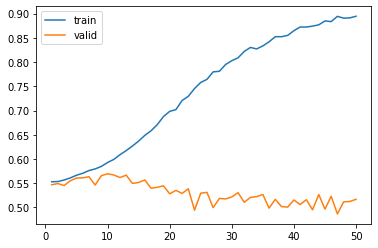

In [134]:
import matplotlib.pyplot as plt
import seaborn as sns
epoch_count = range(1, len(hist2.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist2.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist2.history['val_accuracy'], label='valid')
plt.show()

In [135]:
model2.evaluate(X_test, y_test)

142/142 [==============================] - 1s 7ms/step - loss: 2.6215 - accuracy: 0.5215


[2.621532440185547, 0.5215279459953308]

In [136]:
metricas_multiclase(model2, X_test, y_test)

***Test accuracy:***  0.5215279311106205 

***Confusion matrix:*** 
 [[  21   17   30   24   56]
 [  34   37   65   74   99]
 [  45   79  118  149  197]
 [  24   36   78  266  535]
 [  27   42  122  434 1920]] 

***Classification report:*** 
               precision    recall  f1-score   support

           0       0.14      0.14      0.14       148
           1       0.18      0.12      0.14       309
           2       0.29      0.20      0.24       588
           3       0.28      0.28      0.28       939
           4       0.68      0.75      0.72      2545

    accuracy                           0.52      4529
   macro avg       0.31      0.30      0.30      4529
weighted avg       0.50      0.52      0.51      4529



# CONCLUSIÓN

Debido al desbalance de clases en la variable target, se utilizó el método SMOTE de oversampling. Ambos modelos fueron entrenados sin registrarse overfitting. Sin embargo, el modelo con embeddings propios obtuvo unas métricas promedio de precision y recall ligeramente superiores a las correspondientes al modelo con embeddings pre-entrenados. Sin embargo, podrían obtenerse resultados mas prometedores modificando la arquitectura de las redes.

Previamente a los resultados mostrados, se entrenaron modelos sin recurrir a oversampling. Sin embargo, las métricas de precision y recall resultaron prácticamente iguales a las presentadas aquí.